In [2]:
import numpy as np
from numpy import ndarray
from typing import Callable
from contextlib import contextmanager


In [16]:
class Layer:
    def forward(self, _input: ndarray, train=True) -> ndarray:
        raise NotImplementedError("Forward propagation not implemented")

    def backward(self, prev_grad: ndarray) -> ndarray:
        raise NotImplementedError("Backward propagation not implemented")

In [17]:
class WeightInitializer:
    @staticmethod
    def xavier_init(input_dim: int, output_dim: int) -> ndarray:
        limit = np.sqrt(6 / (input_dim + output_dim))
        return np.random.uniform(-limit, limit, size=(input_dim, output_dim))

    @staticmethod
    def he_init(input_dim: int, output_dim: int) -> ndarray:
        stddev = np.sqrt(2 / input_dim)
        return np.random.normal(0, stddev, size=(input_dim, output_dim))


In [44]:


class Activation(Layer):
    def __init__(self, func: Callable[[ndarray], ndarray], grad: Callable[[ndarray], ndarray]):
        self.func = func
        self.grad = grad
    
    def forward(self, _input: ndarray, train=True) -> ndarray:
        if train:
            self.input = _input
        return self.func(_input)
        
    def backward(self, prev_grad: ndarray) -> ndarray:
        
        return prev_grad * self.grad(self.input)
        
class ReLU(Activation):
    def __init__(self):
        def func(x): return np.maximum(0, x)
        def grad(x): return np.where(x > 0, 1, 0)
        super().__init__(func,grad)
        
    def __repr__(self):
        return "ReLU()"
    
class Sigmoid(Activation):
    def __init__(self):
        def func(x): return 1 / (1 + np.exp(-x))
        def grad(x): return func(x) * (1 - func(x))
        super().__init__(func,grad)
    
    def __repr__(self):
        return "Sigmoid()"
        
class Dense(Layer):
    def __init__(self, input_size: int, output_size: int, * , initializer: Callable[[int, int], ndarray] = WeightInitializer.he_init):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = initializer(input_size, output_size)
        self.bias = np.zeros((1,output_size))
        self.grad_weights: ndarray | None = None
        self.grad_bias: ndarray | None = None
        
        
    
    def forward(self, _input: ndarray, train=True) -> ndarray:
        if train:
            self.input = _input
        return _input.dot(self.weights) + self.bias
    
    def backward(self, prev_grad: ndarray) -> ndarray:
        out_grad = prev_grad.dot(self.weights.T)
        self.grad_weights = self.input.T.dot(prev_grad)
        self.grad_bias = np.sum(prev_grad, axis=0, keepdims=True)
        return out_grad

    def __repr__(self):
        return f"Dense(input={self.input_size}, output={self.output_size})"

In [45]:
class Loss:
    def base(self, y_true: ndarray, y_pred: ndarray) -> ndarray:
        raise NotImplementedError("Base loss function not implemented")

    def grad(self, y_true: ndarray, y_pred: ndarray) -> ndarray:
        raise NotImplementedError("Loss gradient function not implemented")
    
    

In [46]:
class MSE(Loss):
    def base(self, y_true: ndarray, y_pred: ndarray) -> ndarray:
        return np.mean((y_true - y_pred)**2)
    
    def grad(self, y_true: ndarray, y_pred: ndarray) -> ndarray:
        return 2 * (y_pred - y_true) / np.size(y_true) 

    def __repr__(self):
        return "MSE()"


class BCE(Loss):
    def base(self, y_true: ndarray, y_pred: ndarray) -> ndarray:
        return y_true * np.log(y_pred + 1e-9) + (1-y_true) * np.log(1 - y_pred + 1e-9)
    
    def grad(self, y_true: ndarray, y_pred: ndarray) -> ndarray:
        return (y_pred - y_true) / np.size(y_true)
    def __repr__(self):
        return "BCE()"

In [151]:

class Optimizer:
    def __init__(self, layers: list[Layer], lr: float):
        self.layers: list[Dense] = [layer for layer in layers if isinstance(layer, Dense)]
        self.lr = lr
    def step(self, gradient: ndarray):
        raise NotImplementedError("Optimizer Step function not implemented")
    
class SGD(Optimizer):
    def __init__(self, layers: list[Layer], lr: float = 0.1, momentum: float = 0.0):
        self.momentum = momentum
        self.velocity = {}
        super().__init__(layers, lr)
    
    def step(self):
        for idx, layer in enumerate(self.layers):
            if idx not in self.velocity:
                self.velocity[idx] = {
                    'weights': np.zeros_like(layer.weights),
                    'bias': np.zeros_like(layer.bias)
                }
            self.velocity[idx]['weights'] = self.momentum * self.velocity[idx]['weights'] - self.lr * layer.grad_weights
            self.velocity[idx]['bias'] = self.momentum * self.velocity[idx]['bias'] - self.lr * layer.grad_bias
            layer.weights += self.velocity[idx]['weights']
            layer.bias += self.velocity[idx]['bias']
            
    def __repr__(self):
        return f"SGD(lr={self.lr}, momentum={self.momentum})"
    
class RMSProp(Optimizer):
    def __init__(self, layers: list[Layer], lr: float = 0.1, beta = 0.9, epsilon: float = 1e-8):
        self.beta = beta
        self.epsilon = epsilon
        self.cache = {}
        super().__init__(layers, lr)
        
    def step(self):
        for idx, layer in enumerate(self.layers):
            if idx not in self.cache:
                self.cache[idx] = {
                    'weights': np.zeros_like(layer.weights),
                    'bias': np.zeros_like(layer.bias)
                }
            self.cache[idx]['weights'] = (self.beta * self.cache[idx]['weights'] + (1 - self.beta) * (layer.grad_weights ** 2))
            self.cache[idx]['bias'] = (self.beta * self.cache[idx]['bias'] + (1 - self.beta) * (layer.grad_bias ** 2))
            layer.weights -= self.lr * layer.grad_weights  / (np.sqrt(self.cache[idx]['weights'] ) + self.epsilon)
            layer.bias -= self.lr * layer.grad_bias  / (np.sqrt(self.cache[idx]['bias'] ) + self.epsilon)
            
    def __repr__(self):
        return f"RMSProp(lr={self.lr}, beta={self.beta})"

class Adam(Optimizer):
    def __init__(self, layers: list[Layer], lr: float = 0.1, beta1: float = 0.9, beta2: float = 0.99, epsilon: float = 1e-8):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.momentum = {}
        self.velocity = {}
        self.count = 0
        super().__init__(layers, lr)
    
    def step(self):
        self.count += 1
        for idx, layer in enumerate(self.layers):
            if idx not in self.momentum:
                self.momentum[idx] = {
                    'weights': np.zeros_like(layer.weights),
                    'bias': np.zeros_like(layer.bias)
                }
            if idx not in self.velocity:
                self.velocity[idx] = {
                    'weights': np.zeros_like(layer.weights),
                    'bias': np.zeros_like(layer.bias)
                }
        
            self.velocity[idx]['weights'] = (self.beta2 * self.velocity[idx]['weights']) + (1 - self.beta2) * (layer.grad_weights ** 2)
            self.velocity[idx]['bias'] = (self.beta2 * self.velocity[idx]['bias']) + (1 - self.beta2) * (layer.grad_bias ** 2)

            self.momentum[idx]['weights'] = (self.beta1 * self.momentum[idx]['weights']) + (1 - self.beta1) * (layer.grad_weights)
            self.momentum[idx]['bias'] = (self.beta1 * self.momentum[idx]['bias']) + (1 - self.beta1) * (layer.grad_bias)
            
            momentum_denominator = (1 - self.beta1 ** self.count)
            weights_momentum = self.momentum[idx]['weights'] / momentum_denominator
            bias_momentum = self.momentum[idx]['bias'] / momentum_denominator
            
            
            velocity_denominator = (1 - self.beta2 ** self.count)
            weights_velocity = self.velocity[idx]['weights'] / velocity_denominator
            bias_velocity = self.velocity[idx]['bias'] / velocity_denominator

            layer.weights -= self.lr * weights_momentum/(np.sqrt(weights_velocity) + self.epsilon)
            layer.bias -= self.lr * bias_momentum/(np.sqrt(bias_velocity) + self.epsilon)
    def __repr__(self):
        return f"Adam(lr={self.lr}, beta1={self.beta1}, beta2={self.beta2})"

In [152]:

class NN:
    def __init__(self, layers: list[Layer], loss: Loss = MSE ,*, optimizer: Optimizer | None = None):
        self.layers = layers
        self.training = True
        self.loss: Loss = loss()
        self.optimizer: Optimizer | SGD = optimizer or SGD(self.layers)
    def forward(self, _input: ndarray) -> ndarray:
        output = _input
        for layer in self.layers:
            output = layer.forward(output, self.training)
        return output
    
    def backward(self, grad: ndarray) -> ndarray:
        gradient = grad
        for layer in self.layers[::-1]:
            gradient = layer.backward(gradient)
    @contextmanager
    def no_grad(self):
        self.training = False
        yield
        self.training = True
    
    def train(self, X: ndarray, y: ndarray, epochs: int = 1000, batch_size: int = 32) -> ndarray:
        inputs,targets = X,y
        N = inputs.shape[0]
        if len(targets.shape) == 1:
            targets = targets[:,np.newaxis]
        loss_per_epochs = np.zeros(epochs)
        for e in range(epochs):
            batch_idx = np.random.permutation(N)
            batch_iter = (N // batch_size) + (1 if N % batch_size else 0)
            cumm_loss = 0
            for b in range(batch_iter):
                batch = batch_idx[b * batch_size: (b+1) * batch_size]
                batch_inputs, batch_targets = inputs[batch,:], targets[batch,:]
                batch_output = self.forward(batch_inputs)
                cumm_loss += self.loss.base(batch_targets, batch_output)
                gradient = self.loss.grad(batch_targets, batch_output)
                self.backward(gradient)
                self.optimizer.step()
            loss_per_epochs[e] = cumm_loss / batch_iter
        return loss_per_epochs
        
    def __call__(self, _input: ndarray) -> ndarray:
        return self.forward(_input)

                
                

In [153]:
nn = NN([
    Dense(2, 7),
    ReLU(),
    Dense(7, 1, initializer=WeightInitializer.xavier_init),
    Sigmoid()
])
optimizer = SGD(nn.layers)
nn.optimizer = optimizer

In [163]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0,0,0,1])

In [164]:
loss = nn.train(X,y, epochs=100)

In [165]:
import matplotlib.pyplot as plt

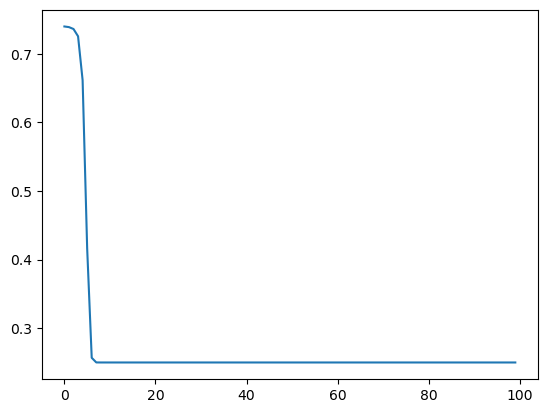

In [166]:
plt.plot(loss)

In [167]:
with nn.no_grad():
    res = nn(X)
    print(np.round(res))
    print(res)
    

[[0.]
 [0.]
 [0.]
 [0.]]
[[4.33538978e-07]
 [1.38775556e-13]
 [1.31158032e-11]
 [1.76680965e-18]]


In [177]:
optimizers = {
    "SGD": SGD,
    "RMSProp": RMSProp,
    "Adam": Adam
}
losses = []
for name, optimizer in optimizers.items():
    nn = NN([
    Dense(2, 7),
    ReLU(),
    Dense(7, 1, initializer=WeightInitializer.xavier_init),
    Sigmoid()
])
    nn.optimizer = optimizer(nn.layers)
    loss = nn.train(X, y, epochs=100)
    losses.append(loss)

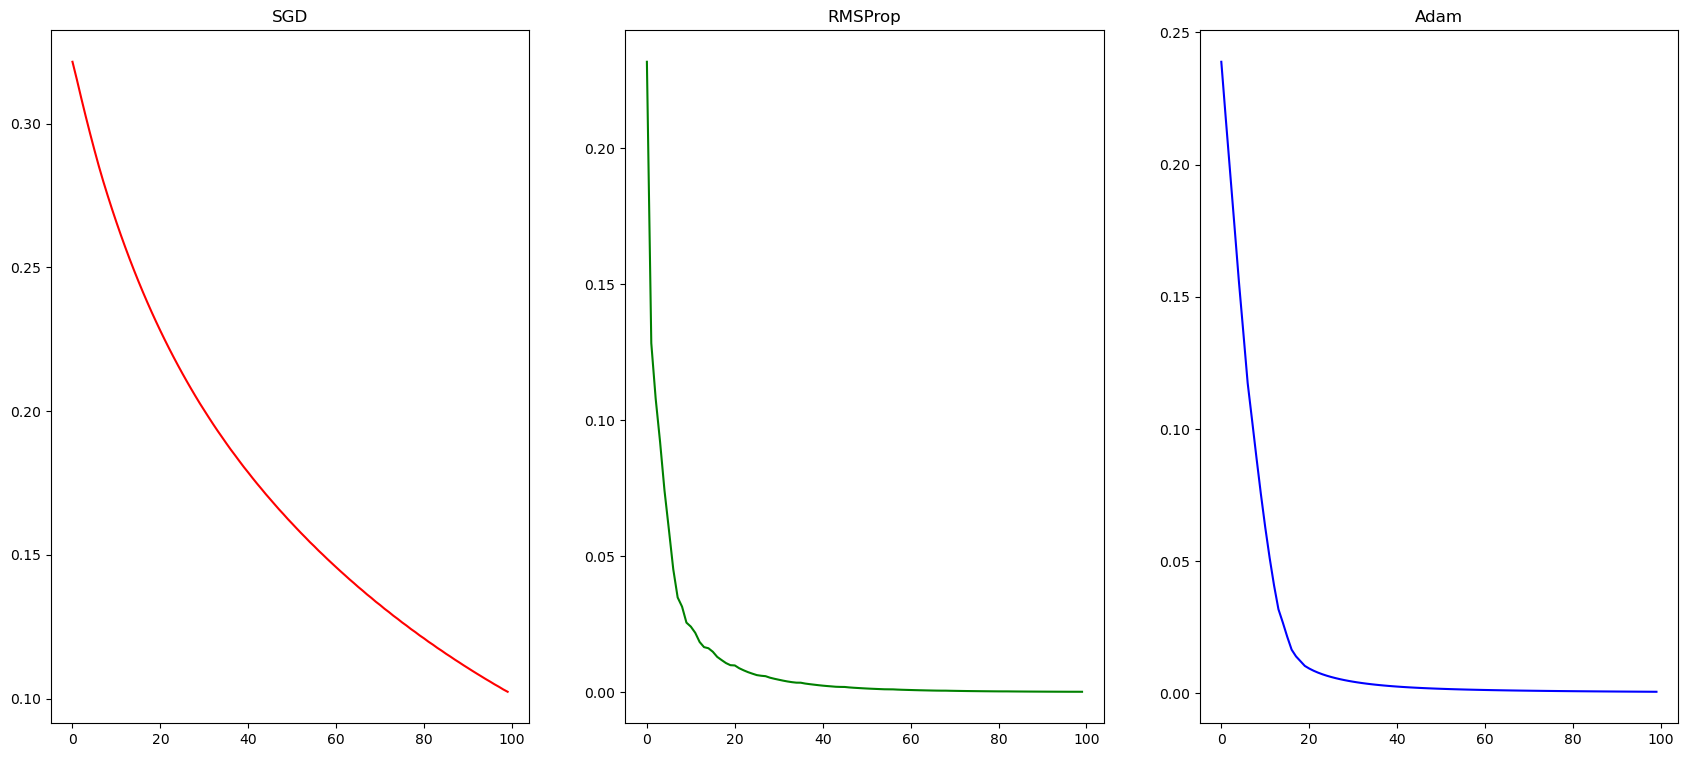

In [178]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(21,9))
c = ['r', 'g', 'b']
names = list(optimizers.keys())
for i,loss in enumerate(losses):
    gs = GridSpec(1,3)
    ax = fig.add_subplot(gs[0,i])
    ax.plot(loss, color=c[i])
    ax.set_title(names[i])